# Project:  Computer Vision - Face Recognition
### By: Krishna Kant Kaushal
### Python version used: Python 3.7.13

### ⌘ Data Description:
#### Aligned Face Dataset from Pinterest

This dataset contains 105 celebrities and 17534 faces. All images are taken from 'Pinterest' and aligned using dlib library.

### ⌘ Objective:
In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces.Here, we are particularly interested in recognizing whether two given facesare of the same person or not.

### ⌘  Steps and Tasks:

● Load the dataset and create the metadata.

● Check some samples of metadata.

● Load the pre-trained model and weights.

● Generate Embedding vectors for each face in the dataset.

● Build distance metrics for identifying the distance between two given images.

● Use PCA for dimensionality reduction.

● Build SVM classifier to map each image to its corresponding celebrity.

● Predict using the SVM model.

 # 🥏 Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# For extracting content from zipfile
from zipfile import ZipFile

# For moodels
import tensorflow
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# For Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# For suppressing warnings
import warnings; warnings.filterwarnings('ignore')

# For setting random_state
random_state = 1729

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the current working directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/10_Computer Vision/Week 7_Advanced Computer Vision Project_Face Identification')

In [ ]:
!ls

 105_classes_pins_dataset
 10KK_Face_Recognition_Solution.ipynb
 AboutFaceDetectionandRecognition.pdf
 celebrity-face-recognition-vggface-model.ipynb
 embeddings_value.npy
'Part 3 - vgg_face_weights.h5'
'Pinterest Face Recognition.zip'
'Project Description - Face Detection.pdf'
 sample.txt
'Train data_images.npy'
'untitled folder'
 vgg_face_weights.h5


In [ ]:
# with ZipFile('Pinterest Face Recognition.zip', 'r') as zip:
#   zip.extractall()

# 🥏 Loading images

Lets define a function that loads the images from the extracted folders and map each image with corresponding celebrity id

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('105_classes_pins_dataset')
labels = np.array([meta.name for meta in metadata])

In [ ]:
print('metadata:', metadata[12],'\nexts:',exts[12])
print(labels[12])

metadata: 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima139_40.jpg 
exts: .jpg
pins_Adriana Lima


In [ ]:
print(labels)
print(type(labels))
print(labels.shape)

['pins_Adriana Lima' 'pins_Adriana Lima' 'pins_Adriana Lima' ...
 'pins_tom ellis' 'pins_tom ellis' 'pins_tom ellis']
<class 'numpy.ndarray'>
(17534,)


# 🥏 Defining function to load images

Lets define a function that loads images from the metadata

In [ ]:
img = cv2.imread(metadata[12].image_path(), 1)
img[12,:,:][0]/255

array([0.21568627, 0.18431373, 0.22352941])

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# 🥏 Loading a sample image

Lets load an image using the above function

(554, 429, 3)
105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima139_40.jpg


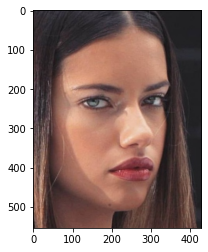


Target is:  Adriana Lima


In [ ]:
n = 12 # np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)
print(img.shape)

print(img_path)
plt.imshow(img)
plt.show()
print("\nTarget is: ",labels[n].split('_')[1])


# 🥏 Create VGG Face model

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

# 🥏 Loading the pre-trained model
Now Lets load the model defined above and load the given weight from file

In [ ]:
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/10_Computer Vision/Week 7_Advanced Computer Vision Project_Face Identification


In [ ]:
model = vgg_face()
model.load_weights('Part 3 - vgg_face_weights.h5')
print(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

# 🥏 Get vgg face descriptor

In [ ]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

# 🥏 Generate embeddings for all images

Lets write code to iterate metadata and create embeddings for images using vgg_face_descriptor.predict() and save in a list with name embeddings

In case of any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
# embeddings = []
# embeddings = np.zeros((metadata.shape[0], 2622))
# for i, meta in tqdm(enumerate(metadata)):
#   try:
#     image = load_image(str(meta))
#     image = (image/255.).astype(np.float32)
#     image = cv2.resize(image, (224, 224))
#     embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
#   except:
#     embeddings[i] = np.zeros(2622)

# # Takes about 3.5 hrs (~1.2 hrs in colab pro) to execute
# print(embeddings[12])

In [ ]:
# # As above code take significat amount of time (3.5+ hrs) to execute lets store the value of 
# # variable 'embeddings' on file and access it when needed so we don't have to run
# # above every time we make any change.

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/10_Computer Vision/Week 7_Advanced Computer Vision Project_Face Identification')

# import numpy as np
# np.save('embeddings_value.npy', embeddings)

In [ ]:
# Retrivieng 'embeddings' from file save by above code:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/10_Computer Vision/Week 7_Advanced Computer Vision Project_Face Identification')

import numpy as np
embeddings = np.load('embeddings_value.npy')

print(type(embeddings))
print(embeddings.shape)
print(embeddings[12])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'numpy.ndarray'>
(17534, 2622)
[ 0.00290275  0.01656329  0.01417118 ... -0.0334307   0.02274423
  0.04572988]


In [ ]:
print(embeddings[2],"\n",embeddings[1280])

print(np.sum(np.square(embeddings[2] - embeddings[1280])))

[ 0.00284581  0.02524843  0.00319399 ... -0.03285725  0.03077788
  0.05085218] 
 [ 0.00642845 -0.00673457 -0.01644186 ... -0.02326827  0.00858663
  0.01097296]
0.7589091369822325


# 🥏 Plot images and get distance between the pairs given below

2, 3 and 2, 180
30, 31 and 30, 100
70, 72 and 70, 115

In [ ]:
# Consider distance metric as "Squared L2 distance"
# Squared L2 distance between points (x1, y1) & (x2, y2) = (x1-x2)^2 + (y1-y2)^2
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.7f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

105_classes_pins_dataset/pins_Anthony Mackie/Anthony Mackie174_476.jpg


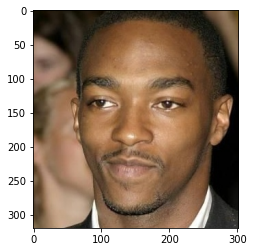


Target is:  Anthony Mackie


In [ ]:
n = 1280 # np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

print(img_path)
plt.imshow(img)
plt.show()
print("\nTarget is: ",labels[n].split('_')[1])

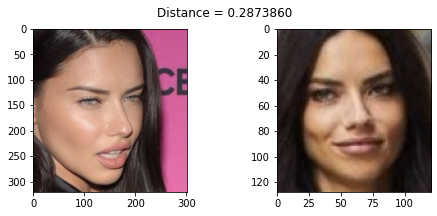

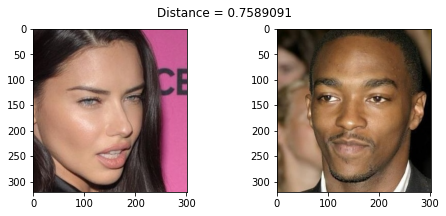

In [ ]:
show_pair(2, 3)
show_pair(2, 1280)

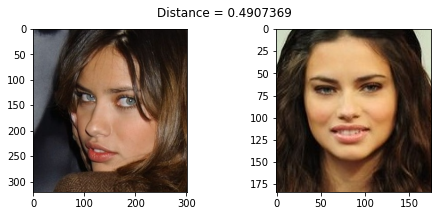

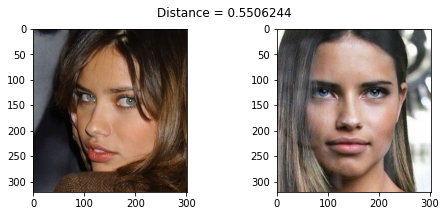

In [ ]:
show_pair(30, 31)
show_pair(30, 100)

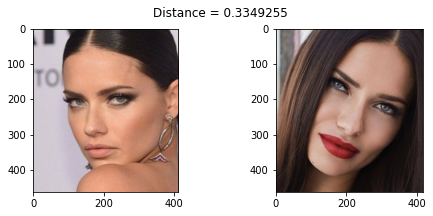

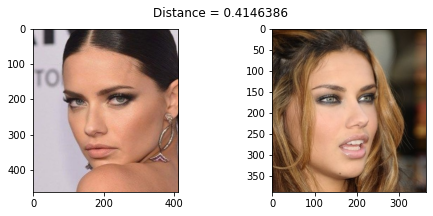

In [ ]:
show_pair(70, 72)
show_pair(70, 115)

# 🥏 Split the data set into train and test sets

Use train_idx to split training features and labels

Use test_idx to split testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0
print("\ntrain_idx: ", train_idx,"\ntest_idx: ", test_idx)

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


train_idx:  [False  True  True ...  True False  True] 
test_idx:  [ True False False ... False  True False]


(15585, 2622)

(1949, 2622)

(15585,)

(1949,)

In [ ]:
print(X_train[12,:])

[ 0.002409    0.02048441  0.00486657 ... -0.03204551  0.01437135
  0.03181522]


# 🥏 Encode the Labels

Lets encode the labels using LabelEncoder.

In [ ]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

# 🥏 Standardize the feature values

Scale the features using StandardScaler

In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# 🥏 Reduce dimensions using PCA

Using Principal Component Analysis, lets reduce feature dimensions.

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained: ', cum_var_exp)

Cumulative Variance Explained:  [ 15.52624921  20.1837876   24.4404785  ...  99.99999975  99.99999999
 100.        ]


# Get index where cumulative variance explained is greater than threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

In [ ]:
# Get index where cumulative variance explained is greater threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 367


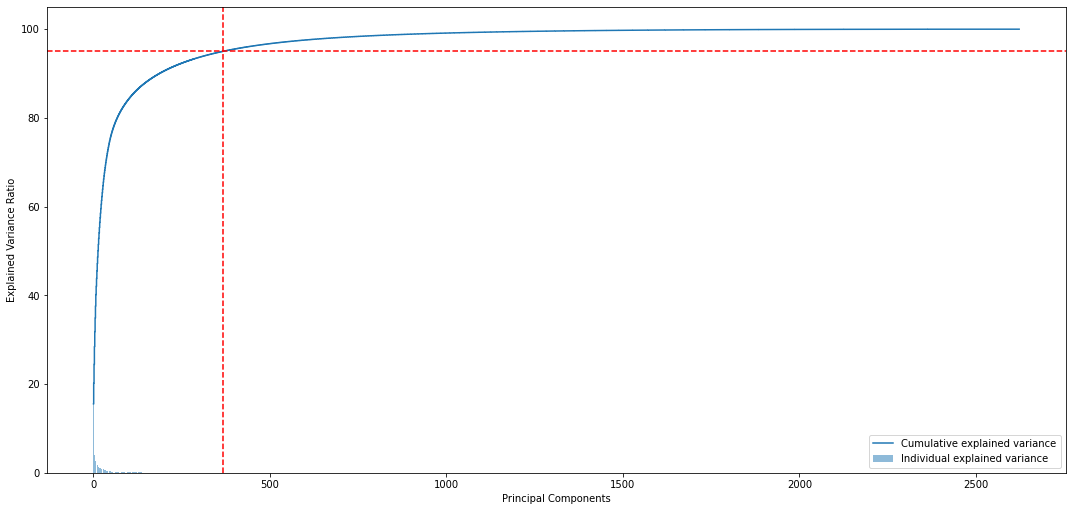

In [ ]:
# Ploting Explained Variance Ratio Vs Principal Components
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

# Takes ~ 1 min to execute

(15585, 367)

(1949, 367)

# 🥏 Build a Classifier

Useing SVM Classifier to predict the celebrity in the given image.

Also fit the classifier and print the score.

In [ ]:
# params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

# svc = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
# svc.fit(X_train_pca, y_train)

# print('Best estimator found by grid search:')
# print(svc.best_estimator_)

# # Best estimator found by grid search:
# # SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

# Takes ~ 4 mins to execute.

SVC accuracy for train set: 0.995


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.977


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                        precision    recall  f1-score   support

          Adriana Lima       1.00      1.00      1.00        24
          Alex Lawther       0.94      1.00      0.97        17
    Alexandra Daddario       1.00      0.96      0.98        25
          Alvaro Morte       1.00      1.00      1.00        15
   Alycia Dabnem Carey       1.00      1.00      1.00        13
           Amanda Crew       1.00      1.00      1.00        22
           Amber Heard       1.00      0.96      0.98        23
          Andy Samberg       1.00      1.00      1.00        14
         Anne Hathaway       1.00      1.00      1.00        18
        Anthony Mackie       1.00      1.00      1.00        14
         Avril Lavigne       1.00      1.00      1.00        13
          Barack Obama       1.00      1.00      1.00        15
        Barbara Palvin       1.00      1.00      1.00        24
           Ben Affleck       1.00      1.00      1.00        11
            Bil

# 🥏 Test results

Take 12th image from test set and plot the image

Report to which celebrity (folder name in dataset) the image corresponds to

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

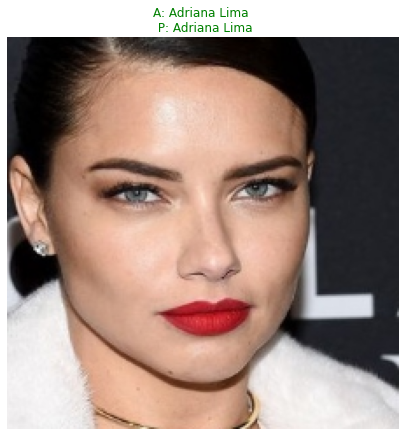

In [ ]:
# Plot for 12th image in test data
sample_img, actual_name, pred_name = sample_img_plot(11)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

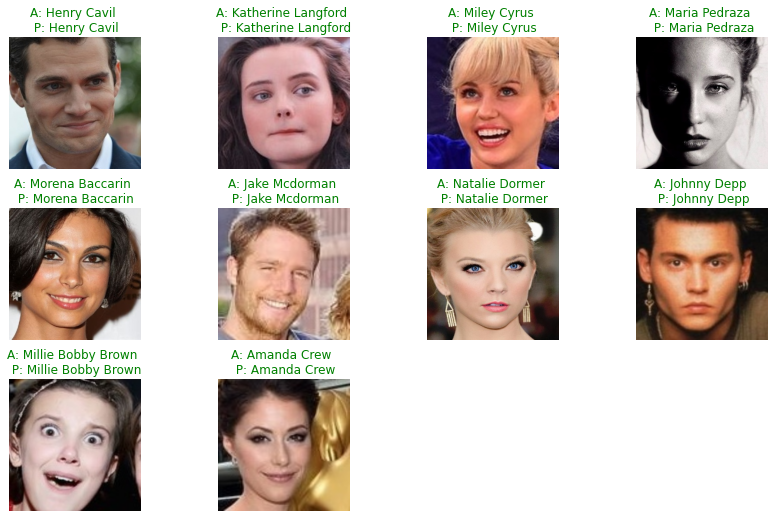

In [ ]:
# Random 10 sample images from test data
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(10):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

# 🥏 Summary:

●  The goal of this project is to recognize faces from a dataset containing 17k+ images of 105 celebrities using a trained model of Face Recognition.

●  For generating embeddings for each image in the dataset, the VGG model having pre-trained weights was used.

●  Distance between two pairs of images was also calculated and plotted.

●  As there are 2622 features for each image, PCA was used for dimension reduction after standardizing the features.

●  347 PCA components were used with a cumulative explained variance of 95%.

●  The test dataset has an accuracy of more than 97.7%.

●  Predicted and actual labels of a given sample image, and of 10 random images from the test dataset were compared.